<a href="https://colab.research.google.com/github/azavalae/fisica_computacional/blob/main/Evaluaci%C3%B3n1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#Lectura y limpieza del data frame.
url = "https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_mlo_DailyData.txt"
df = pd.read_csv(url, encoding='ascii', sep='\s+', skiprows=151, engine='python')
df.drop('hour', inplace=True, axis=1)
df.drop('minute', inplace=True, axis=1)
df.drop('second', inplace=True, axis=1)
df.drop('qcflag', inplace=True, axis=1)
df.replace(to_replace=-999.99, value=np.NaN, inplace=True,)
df['date'] = pd.to_datetime(df[["year", "month", "day"]])
df.drop(df[["year", "month", "day"]], inplace=True, axis=1)
df = df[(df['date'] >= '1980-01-01') & (df['date'] <= '2019-12-31')]
df.ffill(axis = 0, inplace=True)
df.drop(df[['site_code', 'time_decimal', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height']], inplace=True, axis=1)
df['value'] = pd.to_numeric(df["value"])
df = df.set_index(['date'])
df.head(20)



,value
date,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65
1980-01-06,337.25
1980-01-07,337.86
1980-01-08,337.31
1980-01-09,337.31


In [6]:
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

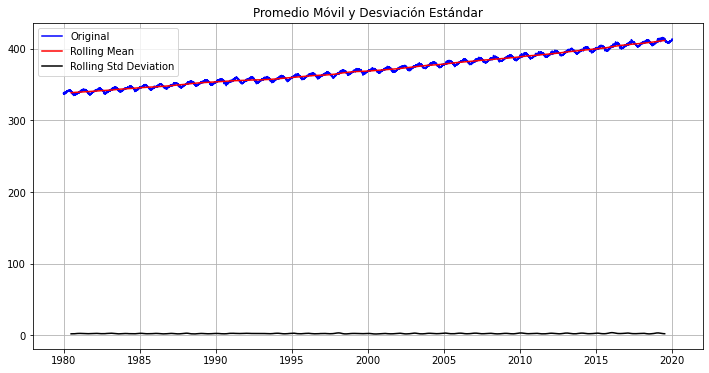

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.014427
p-value                            0.747966
#Lags Used                        42.000000
Number of Observations Used    14567.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [7]:
test_stationarity(df['value'])

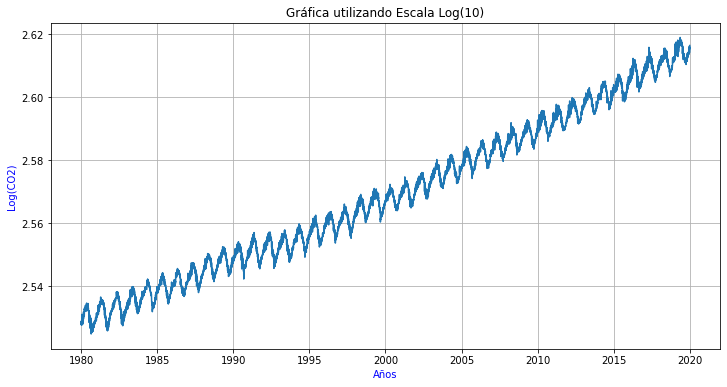

In [8]:
df_log = np.log10(df)
plt.plot(df_log)
plt.xlabel('Años',color='b')
plt.ylabel('Log(CO2)',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

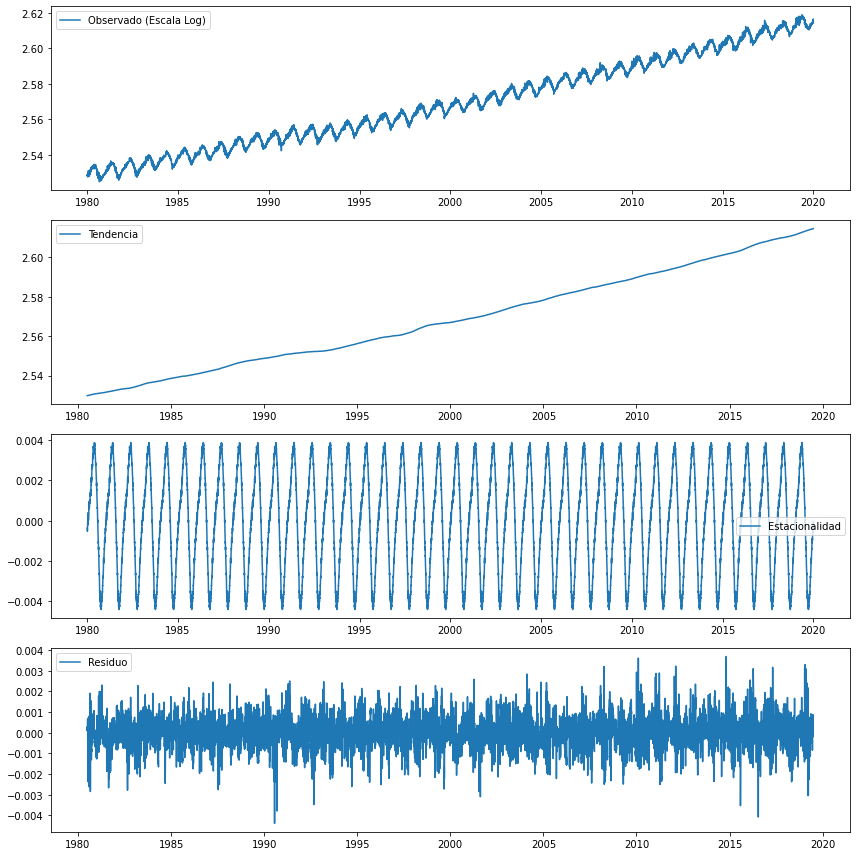

In [9]:
decomposition = sm.tsa.seasonal_decompose(df_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(df_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

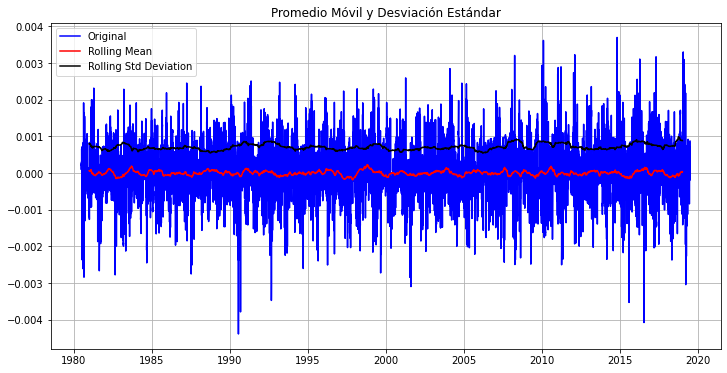

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -19.156045
p-value                            0.000000
#Lags Used                        21.000000
Number of Observations Used    14224.000000
Critical Value (1%)               -3.430810
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


In [10]:
df_log_residue = residue 
df_log_residue.dropna(inplace=True)
test_stationarity(df_log_residue['value'])

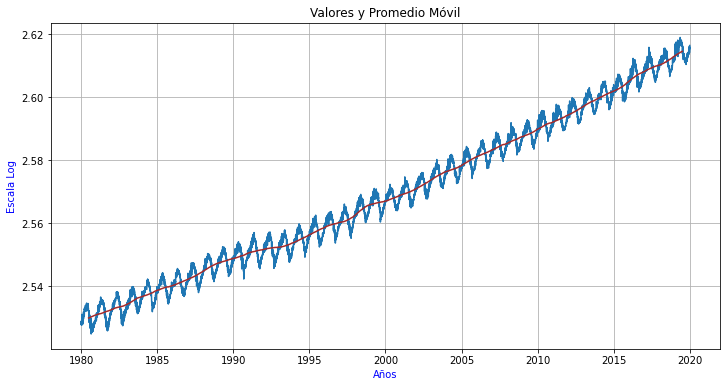

In [18]:
moving_avg = df_log.rolling(365, center=True).mean()
plt.plot(df_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [17]:
df_log_moving_ave_diff = df_log - moving_avg 
df_log_moving_ave_diff.dropna(inplace=True)
df_log_moving_ave_diff.head()

,value
date,
1980-07-01,0.002344
1980-07-02,0.002353
1980-07-03,0.002196
1980-07-04,0.002207
1980-07-05,0.002192


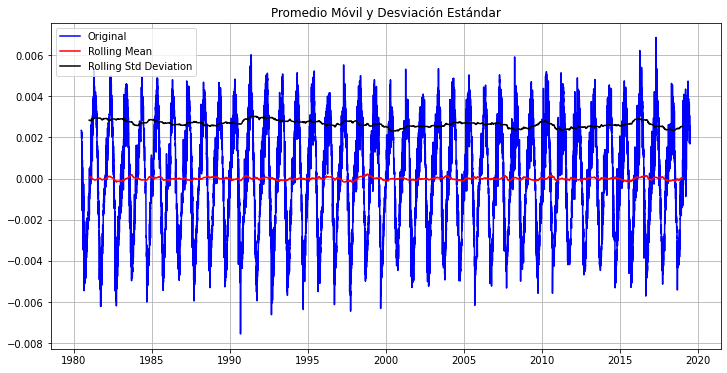

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.400423e+01
p-value                        3.813700e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.420300e+04
dtype: float64


In [185]:
test_stationarity(df_log_moving_ave_diff['value'])

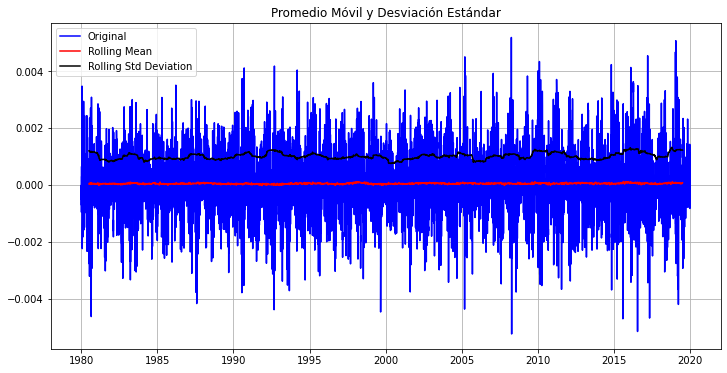

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.002234e+01
p-value                        1.666271e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.456000e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [14]:
df_log_diff = df_log - df_log.shift(periods=7)
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff['value'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


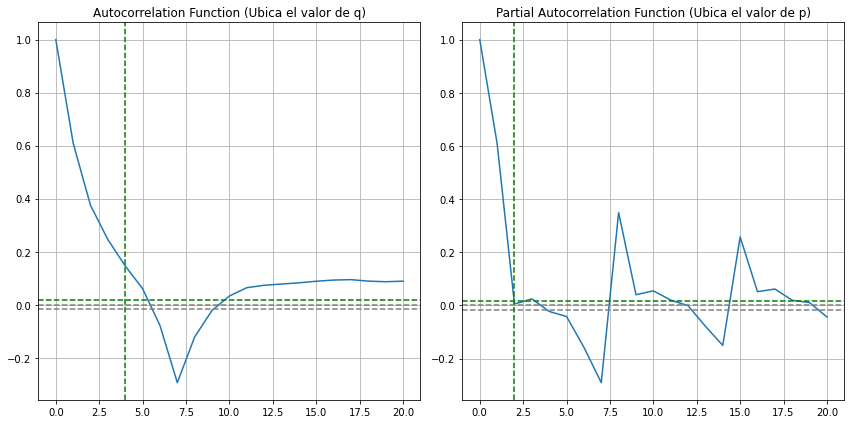

In [19]:

# Aplicamos ARIMA

lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14602
Model:                 ARIMA(2, 1, 0)   Log Likelihood               82347.018
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -164686.037
Time:                        02:06:17   BIC                        -164655.681
Sample:                    01-09-1980   HQIC                       -164675.952
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           9.94e-08   5.02e-06      0.020      0.984   -9.74e-06    9.94e-06
ar.L1.D.value    -0.2358      0.008    -28.978      0.000      -0.252      -0.220
ar.L2.D.value    -0.1826      0.008    -

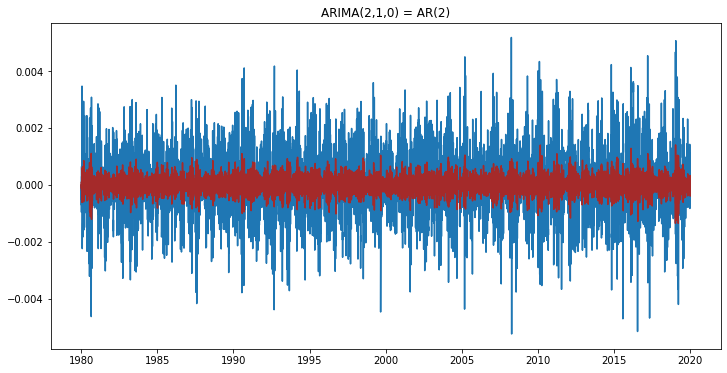

In [20]:
model = ARIMA(df_log_diff, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(df_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14602
Model:                 ARIMA(0, 1, 4)   Log Likelihood               83315.714
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -166619.428
Time:                        02:06:29   BIC                        -166573.895
Sample:                    01-09-1980   HQIC                       -166604.301
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.926e-09   3.27e-07      0.018      0.986   -6.35e-07    6.47e-07
ma.L1.D.value    -0.3913      0.008    -46.985      0.000      -0.408      -0.375
ma.L2.D.value    -0.2375      0.009    -

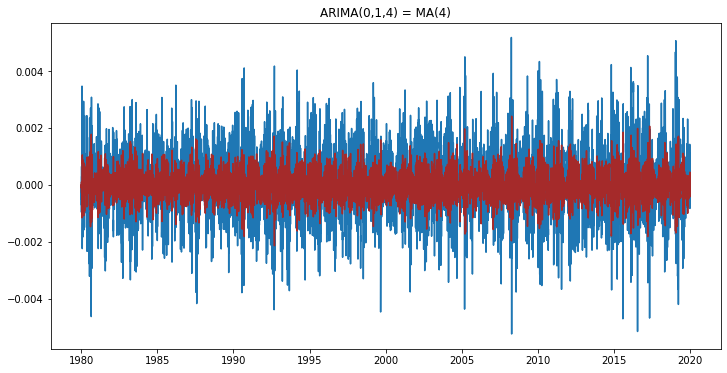

In [21]:
model = ARIMA(df_log_diff, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(df_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14602
Model:                 ARIMA(2, 1, 4)   Log Likelihood               83609.072
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -167202.145
Time:                        02:06:48   BIC                        -167141.433
Sample:                    01-09-1980   HQIC                       -167181.975
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.603e-09   2.36e-07      0.011      0.991   -4.61e-07    4.66e-07
ar.L1.D.value    -0.5084      0.013    -39.453      0.000      -0.534      -0.483
ar.L2.D.value    -0.3699        nan     

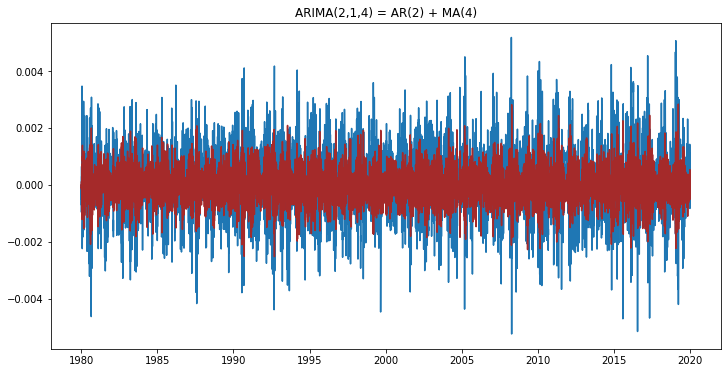

In [22]:
model = ARIMA(df_log_diff, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [23]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

date
1980-01-09    2.603311e-09
1980-01-10   -1.245610e-04
1980-01-11    1.155455e-04
1980-01-12   -1.275169e-04
1980-01-13   -1.730194e-04
                  ...     
2019-12-27    9.551519e-05
2019-12-28   -4.177293e-04
2019-12-29    4.805638e-04
2019-12-30   -1.990030e-04
2019-12-31   -1.429290e-04
Length: 14602, dtype: float64


In [24]:
predictions_ARIMA_log = pd.Series(df_log)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

ValueError: ignored

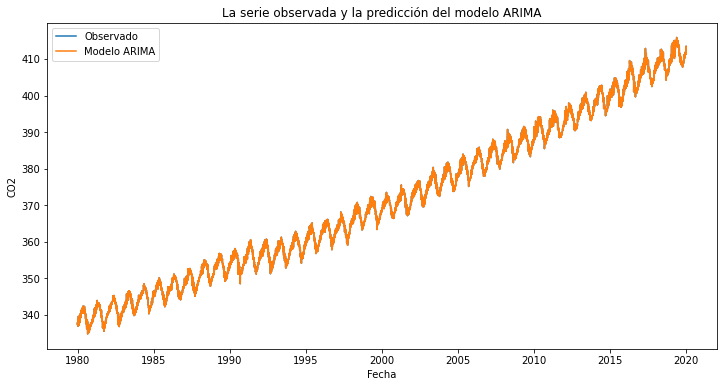

In [28]:
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');